In [ ]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, Batch
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import degree, erdos_renyi_graph, scatter
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, MessagePassing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
torch.manual_seed(45)

# Section 1: Experiments on Synthetic Datasets

## Generate Erdos Renyi Graphs

In [ ]:
def generate_erdos_renyi_graph(n, p, n_features=16):

    edge_index = erdos_renyi_graph(n, p, directed=False)
    x = torch.randn(n, n_features)
    data = Data(x=x, edge_index=edge_index)
    return data


def plot_graph(graph_data, title="Graph"):
    edge_index = graph_data.edge_index.cpu().numpy()
    edges = edge_index.T

    G = nx.Graph()
    G.add_edges_from(edges)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)

    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, node_color='skyblue', font_weight='bold')

    plt.title(title)
    plt.show()

## Create GNN with Customisable Aggregation Methods

In [ ]:
class CustomLayer(MessagePassing):
  def __init__(self, emb_dim, aggr="add", use_relu=True, **kwargs):
    super().__init__(aggr=aggr, **kwargs)
    self.MLP = torch.nn.Sequential(nn.Linear(emb_dim, emb_dim))
    self.aggr = aggr
    self.relu = nn.ReLU() if use_relu else nn.Identity()

  def forward(self, x, edge_index):
    return self.MLP(x + self.propagate(edge_index, x=x))

  def message(self, x_j):
    return self.relu(x_j)

  def aggregate(self, inputs, index, ptr=None, dim_size=None):
    if callable(self.aggr):
      return self.aggr(inputs, index, dim_size)
    else:
      return super().aggregate(inputs, index, ptr=ptr, dim_size=dim_size)

  def update(self, aggr_out):
    return aggr_out

In [ ]:
class CustomGNN(nn.Module):
  def __init__(self, embed_dim, hidden_dim, num_layers, aggr="add"):
    super(CustomGNN, self).__init__()
    self.embed = nn.Linear(embed_dim, hidden_dim)
    self.layers = nn.ModuleList()
    for layer in range(num_layers):
      if layer < num_layers - 1:
        self.layers.append(CustomLayer(hidden_dim, aggr=aggr, use_relu=True))
      else:
        self.layers.append(CustomLayer(hidden_dim, aggr=aggr, use_relu=False))

  def forward(self, x, edge_index):
    x = self.embed(x)
    for layer in range(len(self.layers)):
      x = self.layers[layer](x, edge_index)
    return x

In [ ]:
class StdDevPooling(torch.nn.Module):
    def __init__(self):
        super(StdDevPooling, self).__init__()

    def forward(self, x, batch):
        mean_x = scatter(x, batch, dim=0, reduce='mean')

        squared_diffs = (x - mean_x[batch]) ** 2

        variance = scatter(squared_diffs, batch, dim=0, reduce='mean')

        stddev = torch.sqrt(variance + 1e-6)

        return stddev


## Train Model with Random Features

In [ ]:
epochs = 100
def classify_graphs_with_aggregation(graph_generator, n_graphs=100, n_nodes=50, edge_probs=[0.1, 0.3, 0.5, 0.7], aggregation_methods=['mean'], embed_dim=16, hidden_dim=16):
  graphs = []
  labels = []

  for p in edge_probs:
    for _ in range(n_graphs // len(edge_probs)):
        graph = graph_generator(n_nodes, p)
        graph.y = torch.tensor([edge_probs.index(p)], dtype=torch.long)
        graphs.append(graph)
        labels.append(edge_probs.index(p))

  train_data, test_data, train_labels, test_labels = train_test_split(graphs, labels, test_size=0.2, random_state=42)
  train_batch = Batch.from_data_list(train_data).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
  test_batch = Batch.from_data_list(test_data).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

  results = {}

  for aggregation in aggregation_methods:
    if aggregation == 'add':
      global_pool = global_add_pool
    elif aggregation == 'mean':
      global_pool = global_mean_pool
    elif aggregation == 'max':
      global_pool = global_max_pool
    elif aggregation == 'std':
      global_pool = StdDevPooling()
      global_pool = global_pool.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    else:
      raise ValueError(f"Invalid aggregation method: {aggregation}")
    print(f"Running with aggregation: {aggregation}")

    aggr_metrics = {"train_accuracy": [], "test_accuracy": []}

    model = CustomGNN(embed_dim=embed_dim, hidden_dim=hidden_dim, num_layers=3, aggr=aggregation)
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    pred_layer = nn.Linear(hidden_dim, len(edge_probs))
    pred_layer = pred_layer.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model_param_group = [{"params": model.parameters(), "lr": 0.001}]
    model_param_group.append({"params": pred_layer.parameters(), "lr": 0.001})

    optimizer = optim.Adam(model_param_group, lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      optimizer.zero_grad()
      predicted_train_labels = []
      train_labels = []

      model.train()
      outputs = model(train_batch.x, train_batch.edge_index)
      outputs = global_pool(outputs, train_batch.batch)
      outputs = pred_layer(outputs)
      loss = criterion(outputs, train_batch.y)
      epoch_loss = loss.item()
      loss.backward()
      optimizer.step()

      preds_train = outputs.argmax(dim=1)
      targets_train = train_batch.y
      train_accuracy = accuracy_score(preds_train.detach().cpu().numpy(), targets_train.detach().cpu().numpy())
      aggr_metrics["train_accuracy"].append(train_accuracy)

      model.eval()
      with torch.no_grad():
        outputs = model(test_batch.x, test_batch.edge_index)
        outputs = global_pool(outputs, test_batch.batch)
        outputs = pred_layer(outputs)
        preds_test = outputs.argmax(dim=1)
        targets_test = test_batch.y
        test_accuracy = accuracy_score(preds_test.detach().cpu().numpy(), targets_test.detach().cpu().numpy())
        aggr_metrics["test_accuracy"].append(test_accuracy)

      if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss}, Train Accuracy = {train_accuracy}, Test Accuracy = {test_accuracy}")
    results[aggregation] = aggr_metrics

    model.eval()
    with torch.no_grad():
      outputs = model(test_batch.x, test_batch.edge_index)
      outputs = global_pool(outputs, test_batch.batch)
      outputs = pred_layer(outputs)
      preds_test = outputs.argmax(dim=1)
      targets_test = test_batch.y

      test_accuracy = accuracy_score(preds_test.detach().cpu().numpy(), targets_test.detach().cpu().numpy())

    results[aggregation]["final_test_accuracy"] = test_accuracy
    print(f"Test Accuracy with {aggregation} aggregation: {test_accuracy:.4f}")

  return results

In [ ]:
aggregation_methods = ['add', 'mean', 'max', 'std']
results = classify_graphs_with_aggregation(generate_erdos_renyi_graph, n_graphs=100, n_nodes=50, edge_probs=[0.1, 0.3, 0.5, 0.7], aggregation_methods=aggregation_methods)

Running with aggregation: add
Epoch 0, Loss: 12066.876953125, Train Accuracy = 0.2375, Test Accuracy = 0.15
Epoch 20, Loss: 1820.446533203125, Train Accuracy = 0.4875, Test Accuracy = 0.5
Epoch 40, Loss: 726.1929931640625, Train Accuracy = 0.3875, Test Accuracy = 0.55
Epoch 60, Loss: 284.9283752441406, Train Accuracy = 0.5375, Test Accuracy = 0.4
Epoch 80, Loss: 103.55167388916016, Train Accuracy = 0.6375, Test Accuracy = 0.4
Test Accuracy with add aggregation: 0.4500
Running with aggregation: mean
Epoch 0, Loss: 1.423230528831482, Train Accuracy = 0.25, Test Accuracy = 0.3
Epoch 20, Loss: 1.3788176774978638, Train Accuracy = 0.2875, Test Accuracy = 0.15
Epoch 40, Loss: 1.3562519550323486, Train Accuracy = 0.375, Test Accuracy = 0.2
Epoch 60, Loss: 1.2956711053848267, Train Accuracy = 0.475, Test Accuracy = 0.2
Epoch 80, Loss: 1.1987354755401611, Train Accuracy = 0.4875, Test Accuracy = 0.15
Test Accuracy with mean aggregation: 0.1500
Running with aggregation: max
Epoch 0, Loss: 1.4537

## Plots

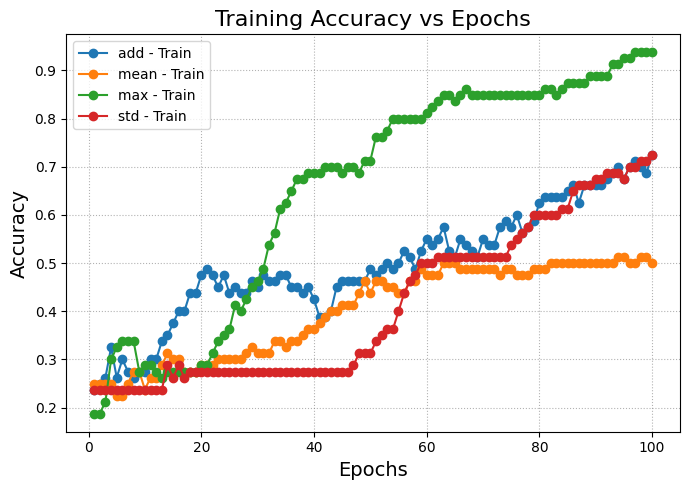

In [ ]:
plt.figure(figsize=(7, 5))

for key, values in results.items():
    plt.plot(range(1, epochs+1), values['train_accuracy'], label=f'{key} - Train', linestyle='-', marker='o')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training Accuracy vs Epochs', fontsize=16)
plt.legend(loc='best')

plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.tight_layout()

plt.savefig('train_accuracy_vs_epochs.png', dpi=300)

plt.show()

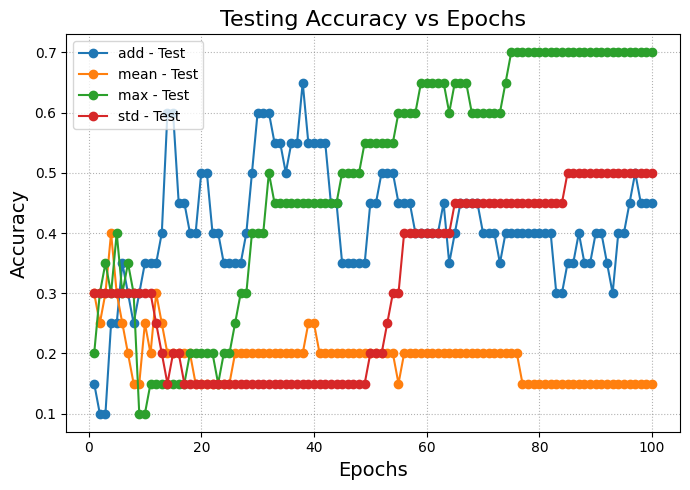

In [ ]:
plt.figure(figsize=(7, 5))


for key, values in results.items():
    plt.plot(range(1, epochs+1), values['test_accuracy'], label=f'{key} - Test', linestyle='-', marker='o')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Testing Accuracy vs Epochs', fontsize=16)
plt.legend(loc='best')

plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.tight_layout()

plt.savefig('testing_accuracy_vs_epochs.png', dpi=300)

plt.show()

## Train Model with Degree Based Features

In [ ]:
def generate_erdos_renyi_graph_degree(n, p):
    edge_index = erdos_renyi_graph(n, p, directed=False)
    node_degrees = degree(edge_index[0], num_nodes=n).long()
    x = torch.zeros(size=(n, n - 1))
    x[torch.arange(n), node_degrees] = 1
    data = Data(x=x, edge_index=edge_index)
    return data

In [ ]:
aggregation_methods = ['add', 'mean', 'max', 'std']
results = classify_graphs_with_aggregation(generate_erdos_renyi_graph_degree, n_graphs=100, n_nodes=50, edge_probs=[0.1, 0.3, 0.5, 0.7], aggregation_methods=aggregation_methods, embed_dim=49, hidden_dim=16)

Running with aggregation: add
Epoch 0, Loss: 2347.477783203125, Train Accuracy = 0.225, Test Accuracy = 0.2
Epoch 20, Loss: 1.8662811517715454, Train Accuracy = 0.8, Test Accuracy = 0.75
Epoch 40, Loss: 0.0019930782727897167, Train Accuracy = 1.0, Test Accuracy = 0.95
Epoch 60, Loss: 8.190324479073752e-06, Train Accuracy = 1.0, Test Accuracy = 1.0
Epoch 80, Loss: 3.715866114362143e-06, Train Accuracy = 1.0, Test Accuracy = 1.0
Test Accuracy with add aggregation: 1.0000
Running with aggregation: mean
Epoch 0, Loss: 1.3887388706207275, Train Accuracy = 0.2375, Test Accuracy = 0.3
Epoch 20, Loss: 1.3066997528076172, Train Accuracy = 0.525, Test Accuracy = 0.4
Epoch 40, Loss: 1.0389660596847534, Train Accuracy = 0.8, Test Accuracy = 0.85
Epoch 60, Loss: 0.47927746176719666, Train Accuracy = 1.0, Test Accuracy = 1.0
Epoch 80, Loss: 0.14911501109600067, Train Accuracy = 1.0, Test Accuracy = 1.0
Test Accuracy with mean aggregation: 1.0000
Running with aggregation: max
Epoch 0, Loss: 1.4186887

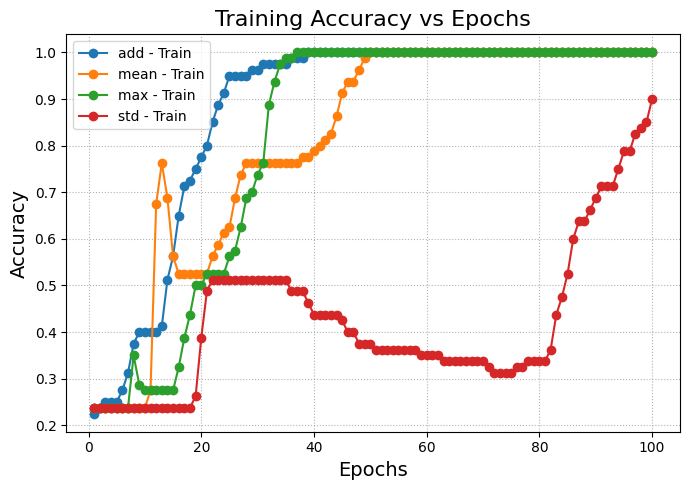

In [ ]:
plt.figure(figsize=(7, 5))

for key, values in results.items():
    plt.plot(range(1, epochs+1), values['train_accuracy'], label=f'{key} - Train', linestyle='-', marker='o')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training Accuracy vs Epochs', fontsize=16)
plt.legend(loc='best')

plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.tight_layout()

plt.savefig('train_accuracy_vs_epochs_degree.png', dpi=300)

plt.show()

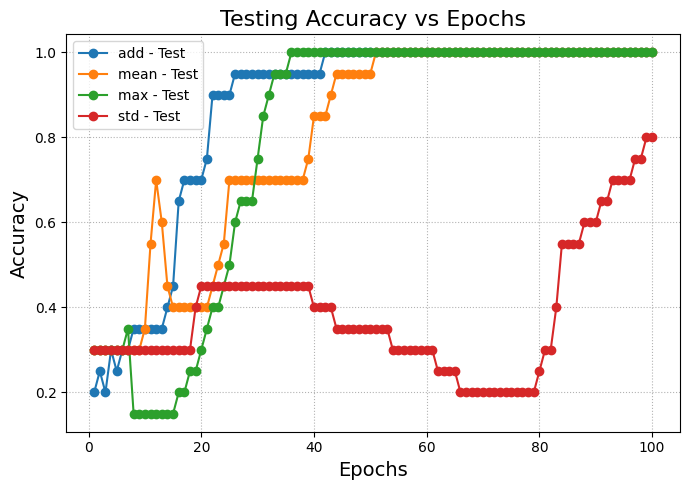

In [ ]:
plt.figure(figsize=(7, 5))


for key, values in results.items():
    plt.plot(range(1, epochs+1), values['test_accuracy'], label=f'{key} - Test', linestyle='-', marker='o')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Testing Accuracy vs Epochs', fontsize=16)
plt.legend(loc='best')

plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.tight_layout()

plt.savefig('testing_accuracy_vs_epochs_degree.png', dpi=300)

plt.show()

# Experiment 2

Fix the number of epochs and increase the size of the graphs. Does the hierarchy change?

In [ ]:
edge_probs = [0.1, 0.3, 0.5, 0.7]
n_graphs = 100
n_nodes = [10 ** i for i in range(1, 3)]
n_nodes.append(500)
graphs = {}
for n in n_nodes:
  graphs[n] = []
  for i in range(n_graphs // len(edge_probs)):
    for p in edge_probs:
      graph = generate_erdos_renyi_graph(n, p)
      graph.y = torch.tensor(edge_probs.index(p), dtype=torch.long)
      graphs[n].append(graph)

  train_graphs, test_graphs = train_test_split(graphs[n], test_size=0.2, random_state=42)
  train_batch = Batch.from_data_list(train_graphs)
  test_batch = Batch.from_data_list(test_graphs)
  graphs[n] = (train_batch, test_batch)

In [ ]:
def train_size_models(graphs, embed_dim, hidden_dim, num_layers, epochs=150, aggregation_methods=["mean"]):
  results = {}
  for aggregation in aggregation_methods:
    if aggregation == 'add':
      global_pool = global_add_pool
    elif aggregation == 'mean':
      global_pool = global_mean_pool
    elif aggregation == 'max':
      global_pool = global_max_pool
    elif aggregation == 'std':
      global_pool = StdDevPooling()
      global_pool = global_pool.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    else:
      raise ValueError(f"Invalid aggregation method: {aggregation}")
    print(f"Running with aggregation: {aggregation}")


    aggr_metrics = {}
    for n in n_nodes:
      aggr_metrics[n] = {}
      train_batch = graphs[n][0]
      test_batch = graphs[n][1]
      train_batch = train_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
      test_batch = test_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

      model = CustomGNN(embed_dim=embed_dim, hidden_dim=hidden_dim, num_layers=3, aggr=aggregation)
      model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

      pred_layer = nn.Linear(hidden_dim, len(edge_probs))
      pred_layer = pred_layer.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

      model_param_group = [{"params": model.parameters(), "lr": 0.001}]
      model_param_group.append({"params": pred_layer.parameters(), "lr": 0.001})

      optimizer = optim.Adam(model_param_group, lr=0.001)
      criterion = nn.CrossEntropyLoss()

      optimizer = optim.Adam(model.parameters(), lr=0.001)
      criterion = nn.CrossEntropyLoss()
      for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        epoch_loss = 0.0
        outputs = model(train_batch.x, train_batch.edge_index)
        outputs = global_pool(outputs, train_batch.batch)
        outputs = pred_layer(outputs)
        loss = criterion(outputs, train_batch.y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
          print(f"Epoch {epoch}, Loss: {epoch_loss}")

      model.eval()
      predicted_test_labels = []
      predicted_train_labels = []
      test_labels = []
      train_labels = []
      with torch.no_grad():
        outputs_test = model(test_batch.x, test_batch.edge_index)
        outputs_test = global_pool(outputs_test, test_batch.batch)
        outputs_test = pred_layer(outputs_test)
        predictions_test = outputs_test.argmax(dim=1)
        targets_test = test_batch.y.unsqueeze(1)

        outputs_train = model(train_batch.x, train_batch.edge_index)
        outputs_train = global_pool(outputs_train, train_batch.batch)
        outputs_train = pred_layer(outputs_train)
        predictions_train = outputs_train.argmax(dim=1)
        targets_train = train_batch.y.unsqueeze(1)

      test_accuracy = accuracy_score(targets_test.detach().cpu().numpy(), predictions_test.detach().cpu().numpy())
      train_accuracy = accuracy_score(targets_train.detach().cpu().numpy(), predictions_train.detach().cpu().numpy())
      print(f"Train Accuracy with n = {n} and aggregation = {aggregation}: {train_accuracy}")
      print(f"Test Accuracy with n = {n} and aggregation = {aggregation}: {test_accuracy}")
      print("\n")
      aggr_metrics[n]["train_accuracy"] = train_accuracy
      aggr_metrics[n]["test_accuracy"] = test_accuracy
    results[aggregation] = aggr_metrics
  return results

In [ ]:
aggregation_methods = ['add', 'mean', 'max', 'std']
results = train_size_models(graphs, embed_dim=16, hidden_dim=16, num_layers=3, epochs=150, aggregation_methods=aggregation_methods)

Running with aggregation: add
Epoch 0, Loss: 63.08467483520508
Epoch 20, Loss: 7.8430376052856445
Epoch 40, Loss: 3.7321829795837402
Epoch 60, Loss: 1.9304851293563843
Epoch 80, Loss: 1.1295616626739502
Epoch 100, Loss: 0.7069869637489319
Epoch 120, Loss: 0.5151888728141785
Epoch 140, Loss: 0.4097049832344055
Train Accuracy with n = 10 and aggregation = add: 0.9
Test Accuracy with n = 10 and aggregation = add: 0.55


Epoch 0, Loss: 314784.9375
Epoch 20, Loss: 39181.265625
Epoch 40, Loss: 9170.4755859375
Epoch 60, Loss: 2885.32470703125
Epoch 80, Loss: 1411.11474609375
Epoch 100, Loss: 821.5621948242188
Epoch 120, Loss: 635.6673583984375
Epoch 140, Loss: 523.9635620117188
Train Accuracy with n = 100 and aggregation = add: 0.625
Test Accuracy with n = 100 and aggregation = add: 0.5


Epoch 0, Loss: 40948748.0
Epoch 20, Loss: 7824700.0
Epoch 40, Loss: 2213822.0
Epoch 60, Loss: 1047349.125
Epoch 80, Loss: 743004.125
Epoch 100, Loss: 529793.0625
Epoch 120, Loss: 353790.34375
Epoch 140, Loss

In [ ]:
for key, values in results.items():
  print(key, values)

add {10: {'train_accuracy': 0.9, 'test_accuracy': 0.55}, 100: {'train_accuracy': 0.625, 'test_accuracy': 0.5}, 500: {'train_accuracy': 0.575, 'test_accuracy': 0.4}}
mean {10: {'train_accuracy': 0.725, 'test_accuracy': 0.25}, 100: {'train_accuracy': 0.575, 'test_accuracy': 0.2}, 500: {'train_accuracy': 0.45, 'test_accuracy': 0.25}}
max {10: {'train_accuracy': 1.0, 'test_accuracy': 0.35}, 100: {'train_accuracy': 1.0, 'test_accuracy': 0.55}, 500: {'train_accuracy': 0.95, 'test_accuracy': 0.55}}
std {10: {'train_accuracy': 0.7875, 'test_accuracy': 0.2}, 100: {'train_accuracy': 0.775, 'test_accuracy': 0.75}, 500: {'train_accuracy': 0.5125, 'test_accuracy': 0.2}}


# Section 2: Experiment on the ENZYMES Dataset

In [ ]:
dataset = TUDataset(root='./data/TUDataset', name='ENZYMES')

train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
epochs = 300

In [ ]:
def train_and_test_classifier(train_loader, test_loader, embed_dim, hidden_dim, num_layers, num_classes, epochs=150, aggregation_methods=["mean"]):
  results = {}
  for aggregation in aggregation_methods:
    if aggregation == 'add':
      global_pool = global_add_pool
    elif aggregation == 'mean':
      global_pool = global_mean_pool
    elif aggregation == 'max':
      global_pool = global_max_pool
    elif aggregation == 'std':
      global_pool = StdDevPooling()
      global_pool = global_pool.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    else:
      raise ValueError(f"Invalid aggregation method: {aggregation}")
    print(f"Running with aggregation: {aggregation}")

    aggr_metrics = {"train_accuracy": [], "test_accuracy": []}

    model = CustomGNN(embed_dim=embed_dim, hidden_dim=hidden_dim, num_layers=3, aggr=aggregation)
    model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    pred_layer = nn.Linear(hidden_dim, num_classes)
    pred_layer = pred_layer.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    model_param_group = [{"params": model.parameters(), "lr": 0.001}]
    model_param_group.append({"params": pred_layer.parameters(), "lr": 0.001})

    optimizer = optim.Adam(model_param_group, lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      model.train()
      epoch_loss = 0.0
      train_accuracies = []
      test_accuracies = []
      for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(batch.x, batch.edge_index)
        outputs = global_pool(outputs, batch.batch)
        outputs = pred_layer(outputs)
        loss = criterion(outputs, batch.y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        preds_train = outputs.argmax(dim=1)
        targets_train = batch.y
        train_accuracies.append(accuracy_score(targets_train.detach().cpu().numpy(), preds_train.detach().cpu().numpy()))



        model.eval()
        with torch.no_grad():
          for test_batch in test_loader:
            batch = test_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = model(test_batch.x, test_batch.edge_index)
            outputs = global_pool(outputs, test_batch.batch)
            outputs = pred_layer(outputs)
            preds_test = outputs.argmax(dim=1)
            targets_test = test_batch.y
            test_accuracies.append(accuracy_score(targets_test.detach().cpu().numpy(), preds_test.detach().cpu().numpy()))
      aggr_metrics["train_accuracy"].append(torch.tensor(train_accuracies).mean().item())
      aggr_metrics["test_accuracy"].append(torch.tensor(test_accuracies).mean().item())

      train_accuracy = torch.tensor(train_accuracies).mean().item()
      test_accuracy = torch.tensor(test_accuracies).mean().item()

      if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss}, Train Accuracy = {train_accuracy}, Test Accuracy = {test_accuracy}")

    print("Training Complete. Testing...")
    test_accuracies = []
    model.eval()
    with torch.no_grad():
      for test_batch in test_loader:
        batch = test_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(test_batch.x, test_batch.edge_index)
        outputs = global_pool(outputs, test_batch.batch)
        outputs = pred_layer(outputs)
        preds_test = outputs.argmax(dim=1)
        targets_test = test_batch.y
        test_accuracies.append(accuracy_score(targets_test.detach().cpu().numpy(), preds_test.detach().cpu().numpy()))
      test_accuracy = torch.tensor(test_accuracies).mean().item()
    print(f"Final Test Accuracy with {aggregation} aggregation: {test_accuracy:.4f}")
    results[aggregation] = aggr_metrics
  return results

In [ ]:
aggregation_methods = ['add', 'mean', 'max', 'std']
results = train_and_test_classifier(train_loader, test_loader, embed_dim=3, hidden_dim=16, num_classes=6, num_layers=3, epochs=epochs, aggregation_methods=aggregation_methods)

Running with aggregation: add
Epoch 0, Loss: 586.9600839614868, Train Accuracy = 0.17083333432674408, Test Accuracy = 0.1874999850988388
Epoch 20, Loss: 33.28141891956329, Train Accuracy = 0.25833332538604736, Test Accuracy = 0.223090261220932
Epoch 40, Loss: 28.047906517982483, Train Accuracy = 0.2562499940395355, Test Accuracy = 0.23315972089767456
Epoch 60, Loss: 27.29440402984619, Train Accuracy = 0.24375000596046448, Test Accuracy = 0.20937499403953552
Epoch 80, Loss: 26.220940589904785, Train Accuracy = 0.27291667461395264, Test Accuracy = 0.25295138359069824
Epoch 100, Loss: 26.839182496070862, Train Accuracy = 0.2979166805744171, Test Accuracy = 0.26788192987442017
Epoch 120, Loss: 25.812365889549255, Train Accuracy = 0.28958332538604736, Test Accuracy = 0.22847221791744232
Epoch 140, Loss: 26.008926033973694, Train Accuracy = 0.28125, Test Accuracy = 0.28402775526046753
Epoch 160, Loss: 25.30899226665497, Train Accuracy = 0.2979166805744171, Test Accuracy = 0.2586805522441864


## Plots

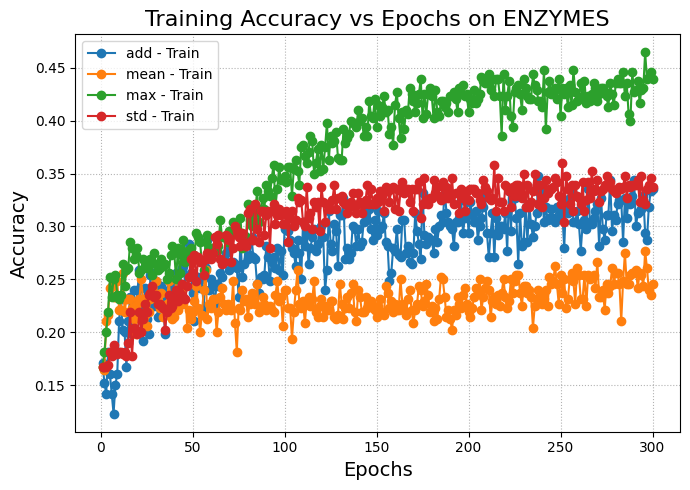

In [ ]:
plt.figure(figsize=(7, 5))

for key, values in results.items():
    plt.plot(range(1, epochs+1), values['train_accuracy'], label=f'{key} - Train', linestyle='-', marker='o')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training Accuracy vs Epochs on ENZYMES', fontsize=16)
plt.legend(loc='best')

plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.tight_layout()

plt.savefig('train_accuracy_vs_epochs_enzymes.png', dpi=300)

plt.show()

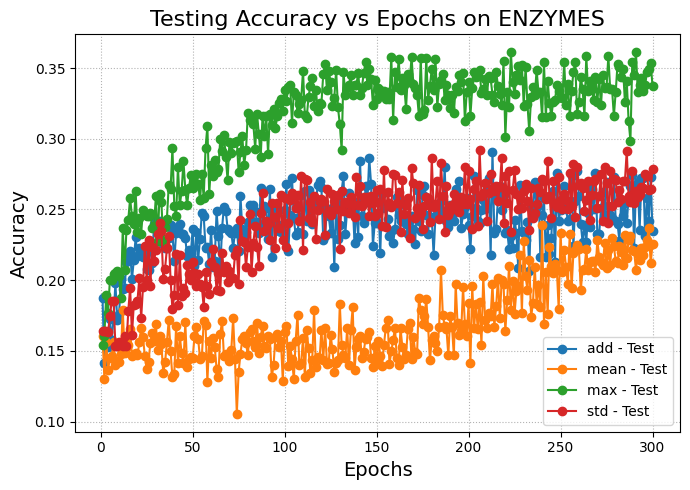

In [ ]:
plt.figure(figsize=(7, 5))

for key, values in results.items():
    plt.plot(range(1, epochs+1), values['test_accuracy'], label=f'{key} - Test', linestyle='-', marker='o')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Testing Accuracy vs Epochs on ENZYMES', fontsize=16)
plt.legend(loc='best')

plt.grid(True, linestyle=':', color='gray', alpha=0.6)
plt.tight_layout()

plt.savefig('test_accuracy_vs_epochs_enzymes.png', dpi=300)

plt.show()